In [1]:
import torch.nn as nn



class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  
        return torch.relu(out)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = ResidualBlock(64, 128, stride=2)
        self.layer2 = ResidualBlock(128, 256, stride=2)
        self.layer3 = ResidualBlock(256, 512, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

In [2]:
import torch
model = CNN()
model.load_state_dict(torch.load("/kaggle/input/cifar10-cnn-residual/pytorch/default/1/cifar10_cnn.pth", weights_only=True))

<All keys matched successfully>

In [3]:
import torchvision.transforms as transforms
import numpy as np
import cv2

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

In [5]:
import torchvision
train = torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform_train)

100%|██████████| 170M/170M [00:02<00:00, 80.1MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [11]:
import random

target_class = torch.tensor([9], dtype=torch.long, device="cuda") 
model = model.to("cuda")
model.eval()
c = 0
l = 0
for i in range(100):
    j = random.randint(1, len(train))
    input_image = train[j][0].unsqueeze(0).to("cuda")
    input_image = input_image.detach().clone()
    input_image.requires_grad_(True)
    output = model(input_image)
    loss = -torch.nn.functional.cross_entropy(output, target_class)
    
    model.zero_grad()
    loss.backward()
    
    with torch.no_grad():
        input_image += 0.1 * input_image.grad.sign()
        input_image.clamp_(0, 1)
    input_image.grad.zero_()
    a = model(input_image)
    pred = torch.argmax(torch.nn.functional.softmax(a, dim=1)).item()
    if pred == train[j][1]:
        c += 1
    l += loss.item()
print(c / 100)
print("average loss", l / 100)

0.21
average loss -10.81037149511711


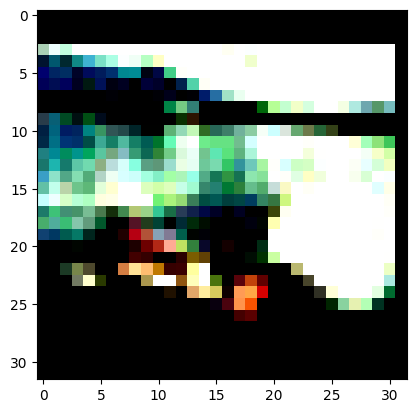

In [7]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(input_image.to("cpu").detach()[0].permute(1, 2, 0))
plt.show()